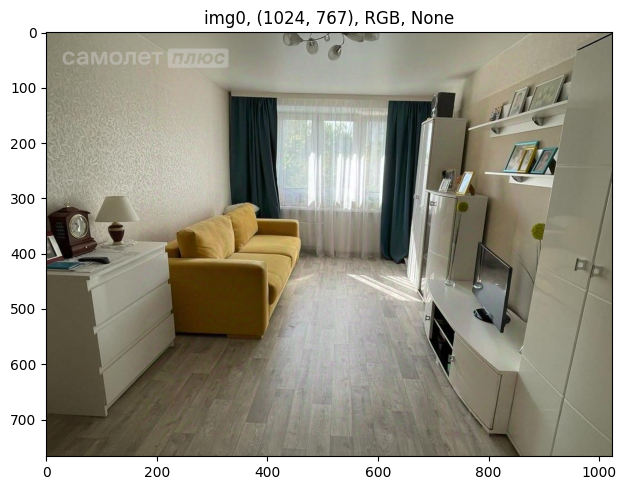

In [1]:
%load_ext autoreload
%autoreload 2

import cv2
import torch
import numpy as np
from pprint import pprint
from PIL import Image, ImageDraw, ImageFont
from utils import display_images, refine_img_morphology, overlay_colored_masks

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"


DEVICE = 'cuda:0'
CACHE_DIR = '/home/a.lugovoi/Git/rnd-tasks/generative-ai-demo/cache'
img_pil = Image.open('data/img5001_BDorig.png').convert('RGB')
display_images([img_pil])

## Grounding DINO

- https://github.com/IDEA-Research/GroundingDINO
- https://huggingface.co/docs/transformers/model_doc/grounding-dino

2024-08-12 21:57:17.969162: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 21:57:17.971884: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 21:57:18.024102: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 21:57:18.675067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[{'boxes': array([[215.0292 , 307.36432, 462.3347 , 555.2256 ]], dtype=float32),
  'labels': ['couch'],
  'scores': array([0.32762933], dtype=float32)}]


/tmp/ipykernel_1257553/1272660774.py:21: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  text_width, text_height = draw.textsize(text, font=font)


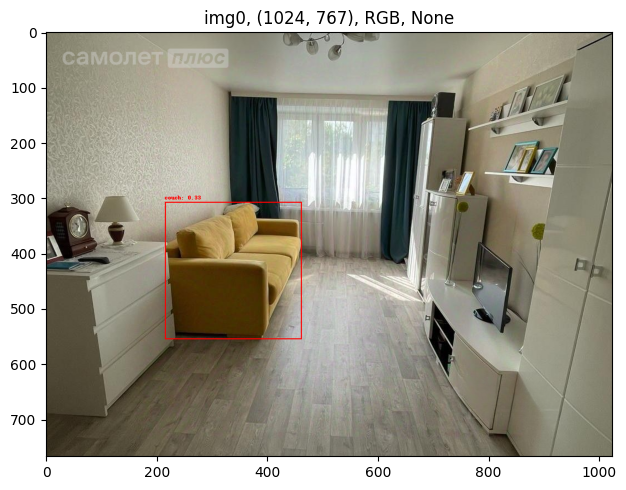

In [2]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection


def draw_boxes_on_image(img_pil, bbox_info):
    img_pil = img_pil.copy()
    draw = ImageDraw.Draw(img_pil)
    
    boxes = bbox_info[0]['boxes']
    labels = bbox_info[0]['labels']
    scores = bbox_info[0]['scores']

    font = ImageFont.load_default()
    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)
        text = f'{label}: {score:.2f}'
        text_width, text_height = draw.textsize(text, font=font)
        draw.text((x1, y1 - text_height - 2), text, fill="red", font=font)

    return img_pil

model_id = "IDEA-Research/grounding-dino-base"
processor = AutoProcessor.from_pretrained(model_id, cache_dir=CACHE_DIR)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id, cache_dir=CACHE_DIR).to(DEVICE)

# inference
text = 'couch'
inputs = processor(images=img_pil, text=text, return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

bbox_info = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.25,
    text_threshold=0.25,
    target_sizes=[img_pil.size[::-1]]
)

# postprocess 
bbox_info[0]['boxes'] = bbox_info[0]['boxes'].cpu().numpy()
bbox_info[0]['scores'] = bbox_info[0]['scores'].cpu().numpy()

pprint(bbox_info)
img_pil_an = draw_boxes_on_image(img_pil, bbox_info)
display_images([img_pil_an])

In [8]:
# import pickle
# with open('bbox_info.pkl', 'wb') as f:
#     pickle.dump(bbox_info, f)

# SAM

- https://github.com/facebookresearch/segment-anything
- https://github.com/IDEA-Research/Grounded-Segment-Anything
- https://huggingface.co/docs/transformers/model_doc/sam

In [2]:
# import pickle
# with open('bbox_info.pkl', 'rb') as f:
#     bbox_info = pickle.load(f)

In [12]:
import torch
from PIL import Image
import requests
from transformers import SamModel, SamProcessor

model_id = "facebook/sam-vit-huge"
model = SamModel.from_pretrained(model_id, cache_dir=CACHE_DIR).to(DEVICE)
processor = SamProcessor.from_pretrained(model_id, cache_dir=CACHE_DIR)

boxes = bbox_info[0]['boxes'].tolist()
inputs = processor(img_pil, input_boxes=[boxes], return_tensors="pt").to(DEVICE)
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu(), mask_threshold=-10
)
scores = outputs.iou_scores

numpy_data = masks[0].numpy().astype('uint8') * 255
image_data = numpy_data[0, 0]
maskl = Image.fromarray(image_data)

# Mask Postprocessing

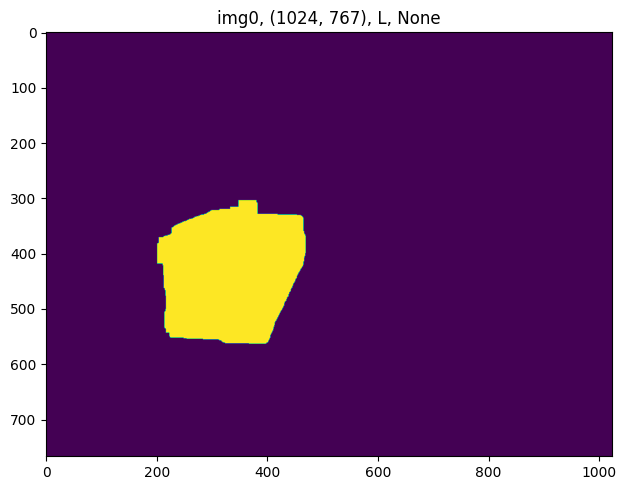

In [13]:
maskl = refine_img_morphology(maskl)
display_images([maskl])

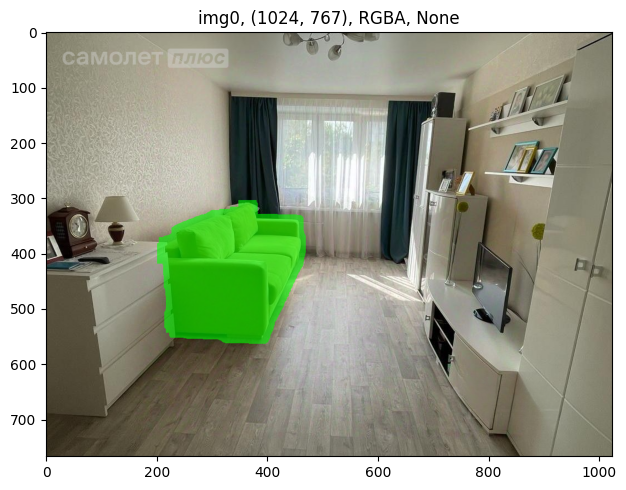

In [14]:
img_pil_colored = overlay_colored_masks(img_pil, [maskl])
display_images([img_pil_colored])

In [27]:
# img_pil_colored.convert('RGB').save('img006_img_pil_colored.jpg')

# Generation (Full Image)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/108 [00:00<?, ?it/s]

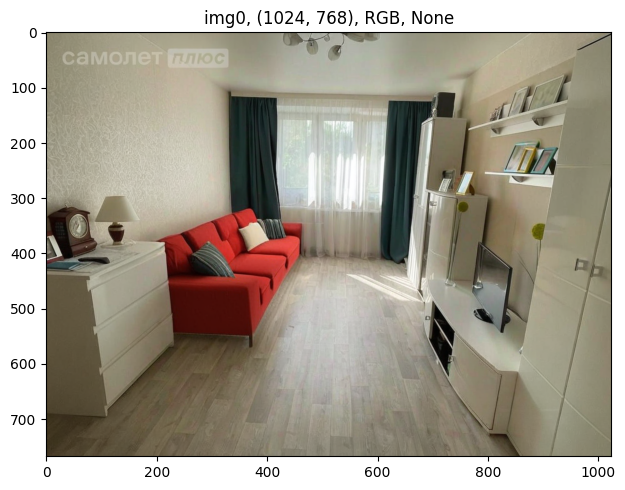

In [39]:
from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image
import torch

# nearest working size
def nearest_multiple(number, multiple=8, prefer_higher=None):
    lower_multiple = (number // multiple) * multiple
    higher_multiple = lower_multiple + multiple
    
    if prefer_higher is None:
        return lower_multiple if abs(number - lower_multiple) <= abs(number - higher_multiple) else higher_multiple
    return higher_multiple if prefer_higher else lower_multiple

height, width = nearest_multiple(img_pil.size[1]), nearest_multiple(img_pil.size[0])

# load pipe
model_id = "diffusers/stable-diffusion-xl-1.0-inpainting-0.1"
pipe = AutoPipelineForInpainting.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    variant="fp16",
    cache_dir=CACHE_DIR
).to(DEVICE)

# inference
prompt = "red couch"
generator = torch.Generator(device=DEVICE).manual_seed(4)

img_generated_pil = pipe(
    prompt=prompt,
    image=img_pil,
    mask_image=mask_l,
    guidance_scale=8.0,
    num_inference_steps=120, 
    strength=0.9,
    height=height,
    width=width,
    generator=generator,
)

img_generated_pil = img_generated_pil.images[0]
display_images([img_generated_pil])

In [41]:
# img_generated_pil.save('img007_generated.jpg')

# Generation (Cropped mask)

In [6]:
def expand_crop_side(current_coords, original_size, target_length):
    start, end = current_coords
    current_length = end - start

    # Вычисление, сколько не хватает до желаемого размера
    delta = target_length - current_length
    if delta <= 0:
        return current_coords  # Текущий размер уже соответствует или превышает целевой

    # Рассчитываем расширение с каждой стороны
    expand_one_side = min(delta // 2, start)
    expand_other_side = min(delta - expand_one_side, original_size - end)

    # Расширяем обрезку
    new_start = start - expand_one_side
    new_end = end + expand_other_side

    # Компенсация, если одна сторона достигла границы
    remaining = delta - (expand_one_side + expand_other_side)
    new_start = max(new_start - remaining, 0) if new_end == original_size else new_start
    new_end = min(new_end + remaining, original_size) if new_start == 0 else new_end

    return (new_start, new_end)


def to_multiplicity_size(start_coord, end_coord, original_size, target_multiple=8):
    """
    делает кратность к target_multiple
    если доступно - расширяет в большую сторону
    если нет - в меньшую
    
    """
    
    size = end_coord - start_coord
    new_size = ((size + target_multiple - 1) // target_multiple) * target_multiple
    diff = new_size - size

    # Попытка увеличить размер
    if end_coord + diff <= original_size:
        end_coord += diff
    elif start_coord - diff >= 0:
        start_coord -= diff
    else:
        # Если увеличить не получается, уменьшаем
        new_size = (size // target_multiple) * target_multiple
        diff = size - new_size
        end_coord = start_coord + new_size

    return start_coord, end_coord

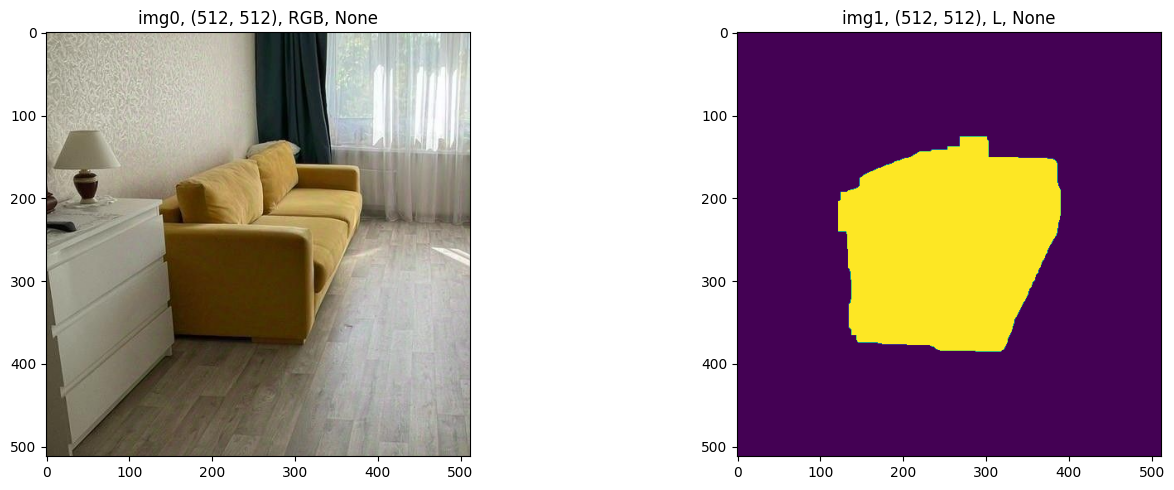

In [16]:
target_width, target_height = 512, 512
original_width, original_height = maskl.size

maskl_np = np.array(maskl)
img_np = np.array(img_pil)

# описываем границы маски прямоугольником
rows, cols = np.where(maskl_np == 255)
top, bottom = np.min(rows), np.max(rows)
left, right = np.min(cols), np.max(cols)

# пытаемся обрезать изображение до желаемого размера
new_left, new_right = expand_crop_side((left, right), original_width, target_width)
new_top, new_bottom = expand_crop_side((top, bottom), original_height, target_height)

# корректируем обрезку до размеров, кратным 8 (условие модели stable diffusion)
new_left, new_right = to_multiplicity_size(new_left, new_right, original_width, 8)
new_top, new_bottom = to_multiplicity_size(new_top, new_bottom, original_height, 8)

crop_coords = (new_left, new_top, new_right, new_bottom)
img_pil_cropped = img_pil.crop(crop_coords).copy()
maskl_cropped = maskl.crop(crop_coords).copy()

width, height = img_orig_pil_cropped.size

display_images([img_pil_cropped, maskl_cropped])

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/108 [00:00<?, ?it/s]

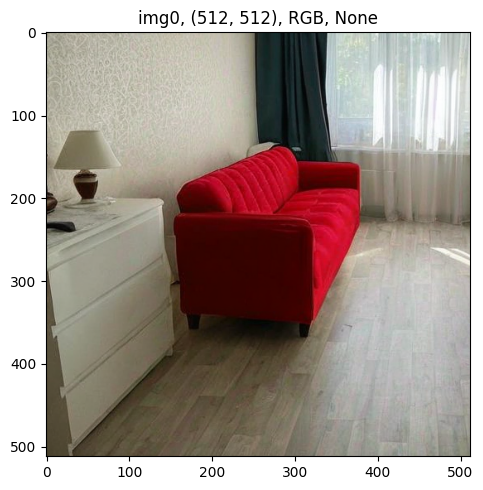

In [19]:
from diffusers import StableDiffusionInpaintPipeline, AutoPipelineForInpainting

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
    safety_checker=None
).to(DEVICE)

# inference
prompt = "red couch"
generator = torch.Generator(device=DEVICE).manual_seed(4)

img_generated_pil = pipe(
    prompt=prompt,
    image=img_pil_cropped,
    mask_image=maskl_cropped,
    guidance_scale=8.0,
    num_inference_steps=120, 
    strength=0.9,
    height=height,
    width=width,
    generator=generator,
)

img_generated_pil = img_generated_pil.images[0]
display_images([img_generated_pil])

In [26]:
repainted_image = img_generated_pil.copy()
init_image = img_pil_cropped.copy()
mask_image_arr = np.array(maskl_cropped.convert("L")).copy()

# Add a channel dimension to the end of the grayscale mask
mask_image_arr = mask_image_arr[:, :, None]

# Binarize the mask: 1s correspond to the pixels which are repainted
mask_image_arr = mask_image_arr.astype(np.float32) / 255.0
mask_image_arr[mask_image_arr < 0.5] = 0
mask_image_arr[mask_image_arr >= 0.5] = 1

# Take the masked pixels from the repainted image and the unmasked pixels from the initial image
unmasked_unchanged_image_arr = (1 - mask_image_arr) * init_image + mask_image_arr * repainted_image
unmasked_unchanged_image = Image.fromarray(unmasked_unchanged_image_arr.round().astype("uint8"))

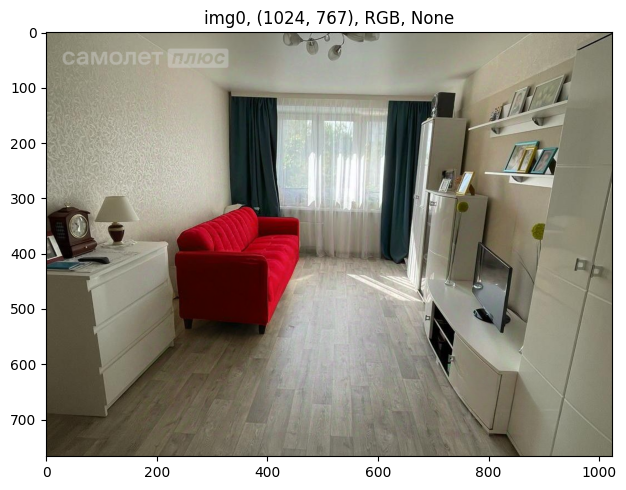

In [27]:
result = img_orig_pil.copy()
result.paste(unmasked_unchanged_image, crop_coords[:2])
display_images([result])

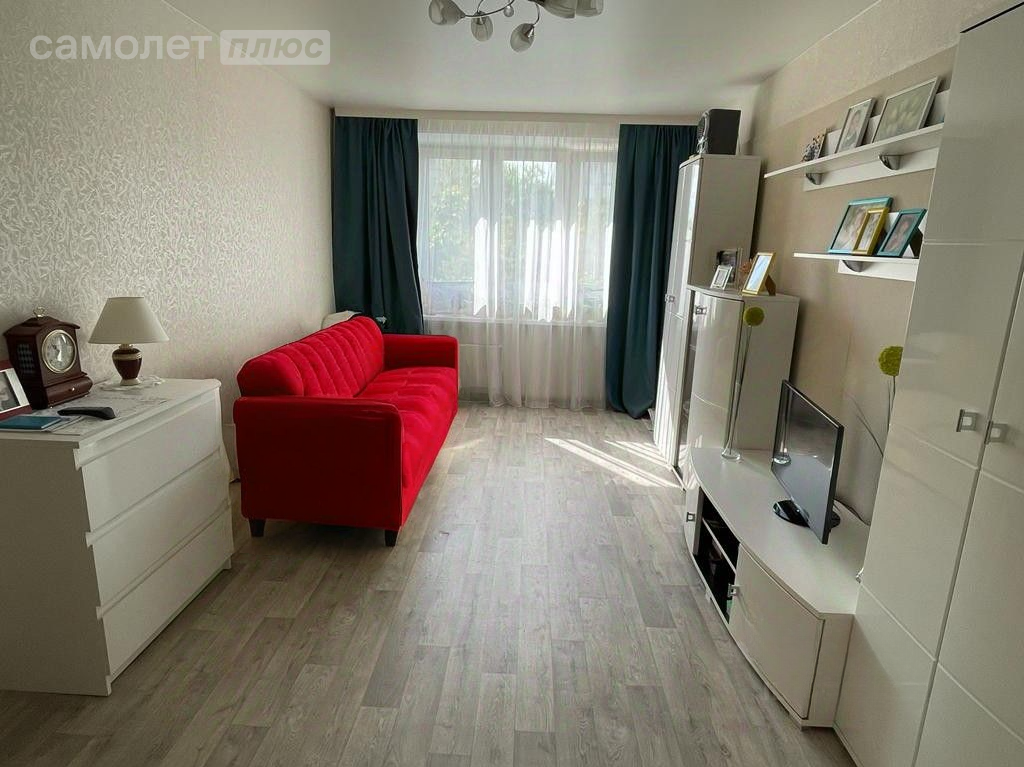

In [30]:
result

In [ ]:
# тут пример LAMA для удаления объекта, если он мелкий

In [ ]:
# тут пример сегментации всей картинки и оставкление только того, что в рамках bbox (большая часть)